# RNN (Recurrent Neural Networks) ile Tahmin - Yinelenen Sinir Ağları

Bu colab dosyasında daha önceki zaman serileri colab dosyalarında oluşturduğumuz zaman serisinin aynısını kullanmaya devam ediyoruz. Mevsimsellik, gürültü gibi tanımlı fonksiyonların yanı sıra `windows_dataset` ve `model_forecast` işlevlerini de tekrar kullanacağız.

1461 adımlık zaman serimizi 1000. adımdan (`split_time`) ayırıp eğitim ve doğrulama periyodumuzu oluşturuyoruz.

## Tanımlamalar ve Gerekli Paketlerin İçeri Aktarılması

Daha önceden aşina olduğum paketleri içeri aktarıyoruz ve işlevleri tekrar kullanabilmek için tanımlıyoruz.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Zaman")
    plt.ylabel("Değer")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Her periyotta aynı kalıbı tekrarlar."""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

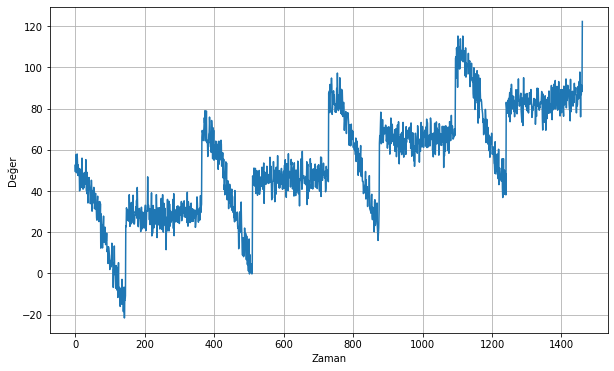

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Basit RNN Tahmini

İlk olarak bir RNN modelimizi oluşturalım.

`keras.backend.clear_session()`: Kerasın arka uç oturumlarını temizler.
`tf.random.set_seed(42)` ve `np.random.seed(42)` : Kodun her çalıştığında aynı çıktıyı vermesini sağlar = Tekrarlanabilirlik sağlar.

Sonra oluşturduğumuz modele bir adet geri arama (`callbacks`) tanımlayalım ve kerasın LearningRateScheduler işlevini kullanalım. Bu işlev sayesinde, eğitim defalarca çalıştırılır ve en iyi sonucu veren öğrenme değeri (`lr_schedule`) bulunur.

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 [==============================] - 5s 61ms/step - loss: 50.2170 - mae: 50.7167
Epoch 2/100
8/8 [==============================] - 1s 55ms/step - loss: 23.0009 - mae: 23.4932
Epoch 3/100
8/8 [==============================] - 0s 43ms/step - loss: 19.2073 - mae: 19.7003
Epoch 4/100
8/8 [==============================] - 0s 44ms/step - loss: 16.9702 - mae: 17.4605
Epoch 5/100
8/8 [==============================] - 0s 43ms/step - loss: 15.4093 - mae: 15.8988
Epoch 6/100
8/8 [==============================] - 0s 49ms/step - loss: 14.7507 - mae: 15.2366
Epoch 7/100
8/8 [==============================] - 0s 50ms/step - loss: 14.3058 - mae: 14.7931
Epoch 8/100
8/8 [==============================] - 0s 47ms/step - loss: 14.0615 - mae: 14.5512
Epoch 9/100
8/8 [==============================] - 0s 45ms/step - loss: 13.7812 - mae: 14.2687
Epoch 10/100
8/8 [==============================] - 0s 46ms/step - loss: 13.5641 - mae: 14.0522
Epoch 11/100
8/8 [==============================]

Öğrenme kaybımız (`loss`) başlangıçta hızlıca düşer sonrasında bir süre yavaş hızda düşüş yaşamaya devam eder. Bir noktadan sonra bir patlamak noktası ile tekar yüksek değerler almaya başlar. Grafikte daha kolay gözlemleyebiliriz:

(1e-07, 0.0001, 0.0, 30.0)

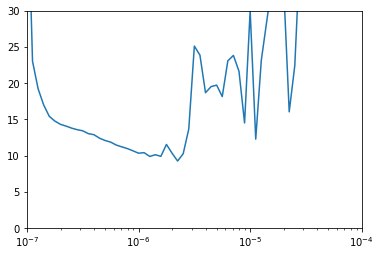

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

Grafiği incelediğimizde en uygun değerin 1e-6 olacağını kabul edebiliriz. 1e-5 değerine ilerlerledikçe seçeceğimiz öğrenme puanı riskli olabilecektir. En uygun `lr` değerimizi bulduğumuza göre modelimizin optimize edici fonksiyonuna parametre olarak bunu verip modelimizi eğitebiliriz.

Modelimizi eğitirken erken durdurma `early_stopping` işlevi tanımlayabiliriz. Eğer modelimiz bir süre boyunca belirli bir ilerleme göstermiyorsa modelin aşırı uyuma geçmesine engel olmak için eğitimi durduruuz. Aşağıdaki kodda `patiance=10` argümanı 10 yinelemede (`epochs`) modelimiz öğrenme açısından ilerleme kaydetmiyorsa durmasını sağlayacaktır.

`early_stopping` gibi bize yardımcı olabilecek bir diğer `callbacks` çeşidi `model_checkpoint`'dir. Kayıt notları (`model_checkpoint`) model eğitilirken modelin durumunun iyiye gittiği her yineleme sonrası modeli bir kayıt noktası olarak kaydeder. Eğitim tamamlandığında en iyi modeli seçerek kullanabiliriz.

Şimdi modelimizi eğitebiliriz. Bulduğumuz `lr` değerini optimize edici fonksiyona verelim.

Bir doğrulama seti oluşturmamız gerektiğini unutmayalım: `valid_set`. Aynı zamanda `fit` içerisinde callbacks listesine tanımladığımız erken durdurma işlevini ve kontrol noktasını eklememiz gerekecektir.

Ve son olarak epochs değerini 500 olarak atıyoruz. Bu deüer oldukça büyük olabilir ancak belli bir epoch sayısından sonra model aşırı uyuma geçme riski oluşturacağı için erken durdurma işlevimiz modelin eğitimini epoch (yineleme) sayısına ulaşmadan bitirecektir.

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
8/8 [==============================] - 2s 106ms/step - loss: 54.8861 - mae: 55.3847 - val_loss: 53.7722 - val_mae: 54.2722
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 2/500
8/8 [==============================] - 1s 64ms/step - loss: 35.4594 - mae: 35.9564 - val_loss: 17.5197 - val_mae: 18.0159
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 3/500
8/8 [==============================] - 1s 58ms/step - loss: 22.5446 - mae: 23.0387 - val_loss: 18.8162 - val_mae: 19.3131
Epoch 4/500
8/8 [==============================] - 1s 66ms/step - loss: 16.2157 - mae: 16.7055 - val_loss: 20.0789 - val_mae: 20.5776
Epoch 5/500
8/8 [==============================] - 1s 62ms/step - loss: 13.7456 - mae: 14.2346 - val_loss: 6.8458 - val_mae: 7.3288
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 6/500
8/8 [==============================] - 1s 60ms/step - loss: 11.3547 - mae: 11.8351 - val_loss: 7.2709 - val_mae: 7.7557
Epoch 7/500
8/8 [==============


Görüldüğü gibi erken durdurma işlevimiz 160. yinelemeden sonra modelimizin eğitimini durdurdu.

En iyi modelimizi seçmek için `keras.models.load_model` işlevini kullanıyoruz ve en başarılı modelimizi `model` adlı değişkene atıyoruz.

Şimdi tahminler yapmak için modelimizi kullanabiliriz. Bunun için zaman serisinin bir kısmını ve pencere boyutunu parametre olarak alan bir tahmin fonksiyonu (model_forecast) oluşturuyoruz. 

In [8]:
model = keras.models.load_model("my_checkpoint")

In [9]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

Şimdi tahminlerimizle gerçek değerlerimizi bir arada grafik üzerinde göserelim. Bunu yapmak için daha önceden tanımladığımız `plot_series` fonksiyonunu kullanabiliriz.

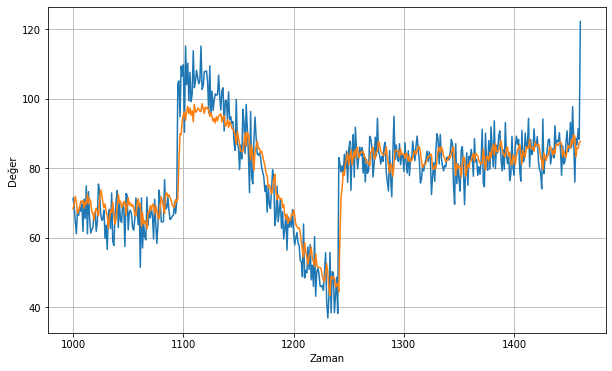

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Modelimizin performansını ölçelim ve ortalama mutlak hata (mae) değerimizi bulalım.

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.328234

## Sıradan Sıraya (Sequence-to-Sequence ) Tahmin Yapılması 

RNN modelimiz için yaptığımız adımların aynısı Sequence-to-Sequence modelimiz için de yapıyoruz. Bu durumda farklı bir veri kümesine ihtiyacımız olacak çünkü etiketler tensörler yerine sıralı şekilde olmalıdır (Sequence-to-Sequence için). İstenilen şartlara uygun veri seti oluşturmak için `seq2seq_window_dataset` işlevi oluşturalım.

In [12]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

Fonksiyonumuzu oluşturuk. Peki makine öğrenmesi için modelere girdi olarak verilecek veriler nasıl görünüyor bir göz atalım.

In [13]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


Normalde kullandığımız `windows_dataset` işlevine oldukça benzer bir işlev tanımladık. `return` anahtar kelimesinden önceki `map` fonksiyonu önceki fonksiyona göre farklıdır. Girdi özellikleri uine aynı olsa da etiketler son değer olmak yerine penceredeki ilk değerler hariç tüm değerler olarak güncellenir.

Tanımlayacağımız yeni model RNN modeline oldukça benzer olacaktır. İlk olarak RNN modelimizin ilk katmanı olan `lambda` katmanını sileriz. Bu katmana ihtiyacımız kalmamıştır çünkü girdi boyutlarımız zaten olması gerektiği gibi doğrudur.

Bununla beraber ikinci `SimpleRNN` katmanımızda ilkinde olduğu gibi `return_sequences=True` argümanı ekliyoruz.

Bu aşamadan sonra tekrar en iyi öğrenme değerinin ne olduğunu bulmamız gerekiyor.

Modele bir adet geri arama (`callbacks`) tanımlayalım ve kerasın LearningRateScheduler işlevini kullanalım. Bu işlev sayesinde, eğitim defalarca çalıştırılır ve en iyi sonucu veren öğrenme değeri (`lr_schedule`) bulunur.



In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 [==============================] - 2s 49ms/step - loss: 52.3615 - mae: 52.8611
Epoch 2/100
8/8 [==============================] - 0s 44ms/step - loss: 25.4713 - mae: 25.9671
Epoch 3/100
8/8 [==============================] - 0s 48ms/step - loss: 23.5029 - mae: 23.9971
Epoch 4/100
8/8 [==============================] - 0s 43ms/step - loss: 21.1367 - mae: 21.6294
Epoch 5/100
8/8 [==============================] - 0s 46ms/step - loss: 19.4762 - mae: 19.9674
Epoch 6/100
8/8 [==============================] - 0s 47ms/step - loss: 18.6742 - mae: 19.1647
Epoch 7/100
8/8 [==============================] - 0s 45ms/step - loss: 18.1698 - mae: 18.6587
Epoch 8/100
8/8 [==============================] - 0s 47ms/step - loss: 17.7679 - mae: 18.2568
Epoch 9/100
8/8 [==============================] - 0s 44ms/step - loss: 17.4389 - mae: 17.9280
Epoch 10/100
8/8 [==============================] - 0s 43ms/step - loss: 17.0989 - mae: 17.5875
Epoch 11/100
8/8 [==============================]


Öğrenme kaybımız (`loss`) başlangıçta hızlıca düşer sonrasında bir süre yavaş hızda düşüş yaşamaya devam eder. Bir noktadan sonra bir patlamak noktası ile tekar yüksek değerler almaya başlar. Grafikte daha kolay gözlemleyebiliriz:

(1e-07, 0.0001, 0.0, 30.0)

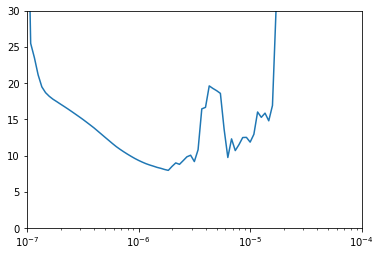

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

Grafiği incelediğimizde en uygun değerin 1e-6 olacağını kabul edebiliriz. 1e-5 değerine ilerlerledikçe seçeceğimiz öğrenme puanı riskli olabilecektir. En uygun `lr` değerimizi bulduğumuza göre modelimizin optimize edici fonksiyonuna parametre olarak bunu verip modelimizi eğitebiliriz.

Modelimizi eğitirken erken durdurma `early_stopping` işlevi tanımlayabiliriz. Eğer modelimiz bir süre boyunca belirli bir ilerleme göstermiyorsa modelin aşırı uyuma geçmesine engel olmak için eğitimi durduruuz. Aşağıdaki kodda `patiance=10` argümanı 10 yinelemede (`epochs`) modelimiz öğrenme açısından ilerleme kaydetmiyorsa durmasını sağlayacaktır.

Bu model için kontrol noktası tanımlamıyoruz. Ama isterseniz nasıl ekleyeceğinizi biliyorsanız. Hatırlamak için RNN modelimize (yukarıdaki) bakabilirsiniz.

Şimdi modelimizi eğitebiliriz. Bulduğumuz `lr` değerini optimize edici fonksiyona verelim.

Bir doğrulama seti oluşturmamız gerektiğini unutmayalım: `valid_set`. Aynı zamanda `fit` içerisinde callbacks listesine tanımladığımız erken durdurma işlevini ve kontrol noktasını eklememiz gerekecektir.

Ve son olarak epochs değerini 500 olarak atıyoruz. Bu deüer oldukça büyük olabilir ancak belli bir epoch sayısından sonra model aşırı uyuma geçme riski oluşturacağı için erken durdurma işlevimiz modelin eğitimini epoch (yineleme) sayısına ulaşmadan bitirecektir.

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
8/8 [==============================] - 2s 98ms/step - loss: 54.1429 - mae: 54.6414 - val_loss: 17.9208 - val_mae: 18.4157
Epoch 2/500
8/8 [==============================] - 1s 57ms/step - loss: 34.1722 - mae: 34.6694 - val_loss: 20.5483 - val_mae: 21.0442
Epoch 3/500
8/8 [==============================] - 1s 58ms/step - loss: 27.5074 - mae: 28.0027 - val_loss: 37.8714 - val_mae: 38.3708
Epoch 4/500
8/8 [==============================] - 1s 61ms/step - loss: 21.0647 - mae: 21.5579 - val_loss: 25.2685 - val_mae: 25.7675
Epoch 5/500
8/8 [==============================] - 1s 60ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3557 - val_mae: 15.8506
Epoch 6/500
8/8 [==============================] - 1s 60ms/step - loss: 15.0383 - mae: 15.5247 - val_loss: 9.4218 - val_mae: 9.9071
Epoch 7/500
8/8 [==============================] - 1s 57ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1617 - val_mae: 9.6474
Epoch 8/500
8/8 [==============================] - 1s 60ms/step - 


Görüldüğü gibi erken durdurma işlevimiz henüz 80. yinelemeden sonra modelimizin eğitimini durdurdu.

Şimdi tahminler yapmak için modelimizi kullanabiliriz. Bunun için zaman serisinin bir kısmını ve pencere boyutunu parametre olarak alan bir tahmin fonksiyonu (`model_forecast`) oluşturmuştuk. Bu işlev sayesinde kolaylıkla yapabiliriz.

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

Şimdi tahminlerimizle gerçek değerlerimizi bir arada grafik üzerinde göserelim. Bunu yapmak için daha önceden tanımladığımız plot_series fonksiyonunu kullanabiliriz.

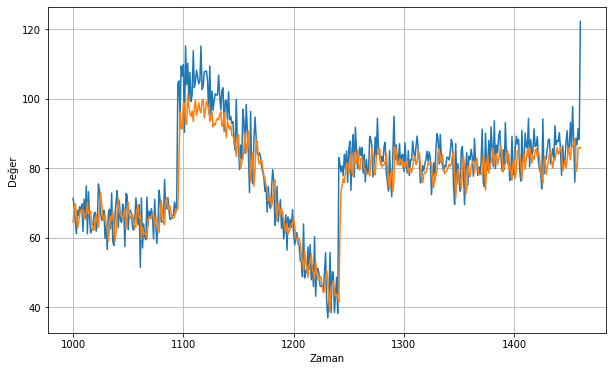

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Modelimizin performansını ölçelim ve ortalama mutlak hata (mae) değerimizi bulalım.

In [20]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.4588723